In [1]:
import gym, gym_futbol_v1
%matplotlib inline
from gym_futbol_v1.envs import Side
from utils import notebook_render_simple, notebook_render_mlp, notebook_render_lstm
from training import ppo2_mlp_policy_train, ppo2_mlp_lstm_policy_train
from stable_baselines import PPO2

Loading chipmunk for Darwin (64bit) [/Users/jim/Library/Python/3.7/lib/python/site-packages/pymunk/libchipmunk.dylib]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



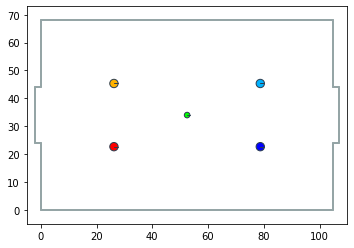

[[52.5        34.          0.          0.        ]
 [26.25       22.66666667  0.          0.        ]
 [26.25       45.33333333  0.          0.        ]
 [78.75       22.66666667  0.          0.        ]
 [78.75       45.33333333  0.          0.        ]]


In [2]:
env = gym.make("futbol-v1")
env.render()
print(env.reset().reshape((-1,4)))

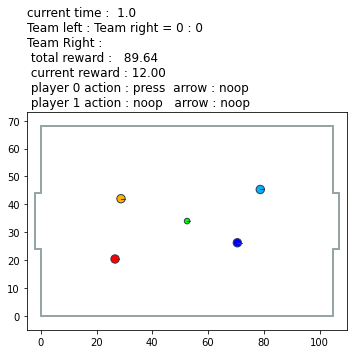

In [3]:
total_reward = notebook_render_simple(env, length=10, random=False, action=[0,3,0,0], side=Side.right)

In [ ]:
model, save_dir = ppo2_mlp_policy_train(time_step=10**4)

In [5]:
best_model = PPO2.load(save_dir + "/best_model")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


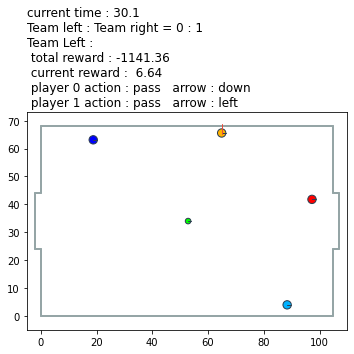

In [6]:
total_reward = notebook_render_mlp('futbol-v1', best_model)

In [4]:
model, save_dir = ppo2_mlp_lstm_policy_train(time_step=10**5)

--------------------------------------
| approxkl           | 0.0034903956  |
| clipfrac           | 0.038085938   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 1.27e+03      |
| explained_variance | -3.99e-05     |
| fps                | 110           |
| n_updates          | 1             |
| policy_entropy     | 6.427124      |
| policy_loss        | -0.0063071577 |
| serial_timesteps   | 128           |
| time_elapsed       | 2.1e-05       |
| total_timesteps    | 1024          |
| value_loss         | 5888.741      |
--------------------------------------
--------------------------------------
| approxkl           | 0.00077049504 |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 1.07e+03      |
| explained_variance | -0.000291     |
| fps                | 294           |
| n_updates          | 2             |
| policy_entropy     | 6.418644      |
| policy_loss        | -0.0004619901 |
| serial_timesteps   | 25

------------------------------------
| approxkl           | 0.021608837 |
| clipfrac           | 0.2980957   |
| ep_len_mean        | 300         |
| ep_reward_mean     | 713         |
| explained_variance | -0.000262   |
| fps                | 313         |
| n_updates          | 16          |
| policy_entropy     | 6.364651    |
| policy_loss        | 0.016955603 |
| serial_timesteps   | 2048        |
| time_elapsed       | 56.2        |
| total_timesteps    | 16384       |
| value_loss         | 5578.616    |
------------------------------------
--------------------------------------
| approxkl           | 0.0003850631  |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 742           |
| explained_variance | 0.000241      |
| fps                | 313           |
| n_updates          | 17            |
| policy_entropy     | 6.347477      |
| policy_loss        | -0.0006493513 |
| serial_timesteps   | 2176          |
| time_elapsed  

--------------------------------------
| approxkl           | 0.00083996245 |
| clipfrac           | 0.0012207031  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 738           |
| explained_variance | 0.00276       |
| fps                | 316           |
| n_updates          | 31            |
| policy_entropy     | 6.331779      |
| policy_loss        | -0.0018843312 |
| serial_timesteps   | 3968          |
| time_elapsed       | 106           |
| total_timesteps    | 31744         |
| value_loss         | 5934.9575     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00071700045 |
| clipfrac           | 0.0           |
| ep_len_mean        | 300           |
| ep_reward_mean     | 706           |
| explained_variance | -0.00096      |
| fps                | 314           |
| n_updates          | 32            |
| policy_entropy     | 6.342511      |
| policy_loss        | -0.0014664722 |
| serial_timesteps   | 40

-------------------------------------
| approxkl           | 0.0020360718 |
| clipfrac           | 0.010009766  |
| ep_len_mean        | 300          |
| ep_reward_mean     | 650          |
| explained_variance | 0.00116      |
| fps                | 314          |
| n_updates          | 46           |
| policy_entropy     | 6.3230915    |
| policy_loss        | -0.002079609 |
| serial_timesteps   | 5888         |
| time_elapsed       | 154          |
| total_timesteps    | 47104        |
| value_loss         | 8901.118     |
-------------------------------------
---------------------------------------
| approxkl           | 0.0020844871   |
| clipfrac           | 0.017578125    |
| ep_len_mean        | 300            |
| ep_reward_mean     | 587            |
| explained_variance | -5.59e-05      |
| fps                | 317            |
| n_updates          | 47             |
| policy_entropy     | 6.3082733      |
| policy_loss        | -0.00033186923 |
| serial_timesteps   | 6016   

-------------------------------------
| approxkl           | 0.0033919502 |
| clipfrac           | 0.021484375  |
| ep_len_mean        | 300          |
| ep_reward_mean     | 640          |
| explained_variance | -0.0012      |
| fps                | 314          |
| n_updates          | 61           |
| policy_entropy     | 6.155485     |
| policy_loss        | 0.0005996237 |
| serial_timesteps   | 7808         |
| time_elapsed       | 203          |
| total_timesteps    | 62464        |
| value_loss         | 10860.052    |
-------------------------------------
--------------------------------------
| approxkl           | 0.00076212466 |
| clipfrac           | 0.0012207031  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 574           |
| explained_variance | 0.0016        |
| fps                | 315           |
| n_updates          | 62            |
| policy_entropy     | 6.1536174     |
| policy_loss        | -7.974307e-05 |
| serial_timesteps   | 7936          |
|

-------------------------------------
| approxkl           | 0.026898146  |
| clipfrac           | 0.33813477   |
| ep_len_mean        | 300          |
| ep_reward_mean     | 590          |
| explained_variance | 0.00179      |
| fps                | 296          |
| n_updates          | 76           |
| policy_entropy     | 6.265956     |
| policy_loss        | 0.0068473155 |
| serial_timesteps   | 9728         |
| time_elapsed       | 253          |
| total_timesteps    | 77824        |
| value_loss         | 695.2546     |
-------------------------------------
-------------------------------------
| approxkl           | 0.0014992649 |
| clipfrac           | 0.0034179688 |
| ep_len_mean        | 300          |
| ep_reward_mean     | 583          |
| explained_variance | 0.000613     |
| fps                | 308          |
| n_updates          | 77           |
| policy_entropy     | 6.269136     |
| policy_loss        | -0.003272575 |
| serial_timesteps   | 9856         |
| time_elaps

------------------------------------
| approxkl           | 0.009315766 |
| clipfrac           | 0.1394043   |
| ep_len_mean        | 300         |
| ep_reward_mean     | 608         |
| explained_variance | -0.000525   |
| fps                | 314         |
| n_updates          | 91          |
| policy_entropy     | 5.854322    |
| policy_loss        | 0.004409468 |
| serial_timesteps   | 11648       |
| time_elapsed       | 302         |
| total_timesteps    | 93184       |
| value_loss         | 14451.787   |
------------------------------------
--------------------------------------
| approxkl           | 0.006976198   |
| clipfrac           | 0.095214844   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 630           |
| explained_variance | 0.0151        |
| fps                | 309           |
| n_updates          | 92            |
| policy_entropy     | 5.895903      |
| policy_loss        | -0.0005400653 |
| serial_timesteps   | 11776         |
| time_elapsed  

In [6]:
model.learn(total_timesteps=10**5)

-------------------------------------
| approxkl           | 0.0014423786 |
| clipfrac           | 0.0075683594 |
| ep_len_mean        | 300          |
| ep_reward_mean     | 654          |
| explained_variance | 0.00118      |
| fps                | 314          |
| n_updates          | 1            |
| policy_entropy     | 5.7732983    |
| policy_loss        | -0.002052912 |
| serial_timesteps   | 128          |
| time_elapsed       | 1.6e-05      |
| total_timesteps    | 1024         |
| value_loss         | 19826.951    |
-------------------------------------
--------------------------------------
| approxkl           | 0.0013883809  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 641           |
| explained_variance | -0.00646      |
| fps                | 319           |
| n_updates          | 2             |
| policy_entropy     | 5.7572136     |
| policy_loss        | -0.0015745875 |
| serial_timesteps   | 256           |
|

------------------------------------
| approxkl           | 0.024554593 |
| clipfrac           | 0.33374023  |
| ep_len_mean        | 300         |
| ep_reward_mean     | 788         |
| explained_variance | 0.000826    |
| fps                | 312         |
| n_updates          | 16          |
| policy_entropy     | 5.540352    |
| policy_loss        | 0.01760319  |
| serial_timesteps   | 2048        |
| time_elapsed       | 48.6        |
| total_timesteps    | 16384       |
| value_loss         | 9952.343    |
------------------------------------
--------------------------------------
| approxkl           | 0.0013121859  |
| clipfrac           | 0.0048828125  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 724           |
| explained_variance | 0.00233       |
| fps                | 311           |
| n_updates          | 17            |
| policy_entropy     | 5.593919      |
| policy_loss        | -0.0020801965 |
| serial_timesteps   | 2176          |
| time_elapsed  

--------------------------------------
| approxkl           | 0.0018395933  |
| clipfrac           | 0.0068359375  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 622           |
| explained_variance | -0.000966     |
| fps                | 336           |
| n_updates          | 31            |
| policy_entropy     | 5.7558327     |
| policy_loss        | 0.00014052272 |
| serial_timesteps   | 3968          |
| time_elapsed       | 96.6          |
| total_timesteps    | 31744         |
| value_loss         | 12206.163     |
--------------------------------------
--------------------------------------
| approxkl           | 0.004694177   |
| clipfrac           | 0.06542969    |
| ep_len_mean        | 300           |
| ep_reward_mean     | 622           |
| explained_variance | -0.000832     |
| fps                | 341           |
| n_updates          | 32            |
| policy_entropy     | 5.7385        |
| policy_loss        | -0.0044946247 |
| serial_timesteps   | 40

--------------------------------------
| approxkl           | 0.00084286224 |
| clipfrac           | 0.0012207031  |
| ep_len_mean        | 300           |
| ep_reward_mean     | 402           |
| explained_variance | -0.000195     |
| fps                | 342           |
| n_updates          | 46            |
| policy_entropy     | 5.4211698     |
| policy_loss        | 0.0028193977  |
| serial_timesteps   | 5888          |
| time_elapsed       | 141           |
| total_timesteps    | 47104         |
| value_loss         | 20104.158     |
--------------------------------------
--------------------------------------
| approxkl           | 0.007210392   |
| clipfrac           | 0.10449219    |
| ep_len_mean        | 300           |
| ep_reward_mean     | 411           |
| explained_variance | -0.00234      |
| fps                | 342           |
| n_updates          | 47            |
| policy_entropy     | 5.4371076     |
| policy_loss        | 5.5423647e-05 |
| serial_timesteps   | 60

--------------------------------------
| approxkl           | 0.0010085956  |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 544           |
| explained_variance | 0.00265       |
| fps                | 340           |
| n_updates          | 61            |
| policy_entropy     | 5.698589      |
| policy_loss        | -0.0009080399 |
| serial_timesteps   | 7808          |
| time_elapsed       | 186           |
| total_timesteps    | 62464         |
| value_loss         | 657.21405     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0027570906  |
| clipfrac           | 0.026855469   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 551           |
| explained_variance | 0.013         |
| fps                | 341           |
| n_updates          | 62            |
| policy_entropy     | 5.7237487     |
| policy_loss        | -0.0017967436 |
| serial_timesteps   | 79

--------------------------------------
| approxkl           | 0.0043458813  |
| clipfrac           | 0.041748047   |
| ep_len_mean        | 300           |
| ep_reward_mean     | 444           |
| explained_variance | 0.0269        |
| fps                | 342           |
| n_updates          | 76            |
| policy_entropy     | 5.7005553     |
| policy_loss        | -0.0030920461 |
| serial_timesteps   | 9728          |
| time_elapsed       | 231           |
| total_timesteps    | 77824         |
| value_loss         | 553.218       |
--------------------------------------
---------------------------------------
| approxkl           | 0.0029914088   |
| clipfrac           | 0.025390625    |
| ep_len_mean        | 300            |
| ep_reward_mean     | 410            |
| explained_variance | 0.000524       |
| fps                | 340            |
| n_updates          | 77             |
| policy_entropy     | 5.688066       |
| policy_loss        | -0.00041803348 |
| serial_timest

--------------------------------------
| approxkl           | 0.015374401   |
| clipfrac           | 0.23779297    |
| ep_len_mean        | 300           |
| ep_reward_mean     | 579           |
| explained_variance | 0.00717       |
| fps                | 340           |
| n_updates          | 91            |
| policy_entropy     | 5.2856655     |
| policy_loss        | -0.0005996807 |
| serial_timesteps   | 11648         |
| time_elapsed       | 276           |
| total_timesteps    | 93184         |
| value_loss         | 4410.0615     |
--------------------------------------
--------------------------------------
| approxkl           | 0.0008185889  |
| clipfrac           | 0.00390625    |
| ep_len_mean        | 300           |
| ep_reward_mean     | 567           |
| explained_variance | 0.00212       |
| fps                | 343           |
| n_updates          | 92            |
| policy_entropy     | 5.27776       |
| policy_loss        | 1.2598146e-05 |
| serial_timesteps   | 11

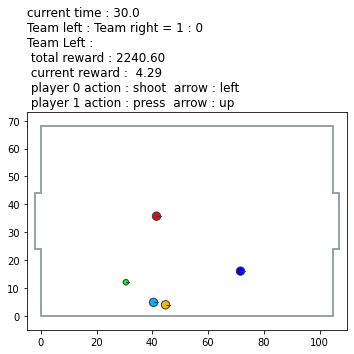

In [7]:
total_reward = notebook_render_lstm('futbol-v1', model)